## Training a heteroskedastic GP using BoTorch

    - Matt Robinson

The example datasets used herein are those described as benchmark datasets G, Y, and W in http://people.csail.mit.edu/kersting/papers/kersting07icml_mlHetGP.pdf

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install botorch

     |████████████████████████████████| 112kB 9.9MB/s 
     |████████████████████████████████| 194kB 33.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/20/75/11/d5c644ac2b81bc933637a78a26d582577d114afa13da408027
Successfully built gpytorch


### Set Random Seed for reproducibility

In [ ]:
import math
import torch
import botorch
import gpytorch
import fastai
from fastai.tabular import *

seed = 42

# python RNG
random.seed(seed)

# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
np.random.seed(seed)

### Benchmark Dataset G

>
"
The synthetic data originally used by Goldberg
et al. (1998): $100$ points $x_i$ have been chosen uniformly spaced in the interval [0, 1] and the targets
$t_i = 2 \sin(2πx_i) $ have been corrupted with a Gaussian
noise where the standard deviation increases linearly
from $0.5$ at $x = 0$ to $1.5$ at $x = 1$.
"
>

Note that I am going to use more data, just because I can, plus I don't really care about comparing to their results right now:

In [ ]:
# show the distribution
G_x = np.linspace(0,1,100)
G_y = 2*np.sin(2*np.pi*G_x) + np.random.normal(loc=0, scale=(0.5+1*G_x), size=100)

In [ ]:
X_train = torch.tensor(G_x.reshape(-1,1), dtype=torch.float)
y_train = torch.tensor(G_y, dtype=torch.float)

Text(0, 0.5, 'G_y')

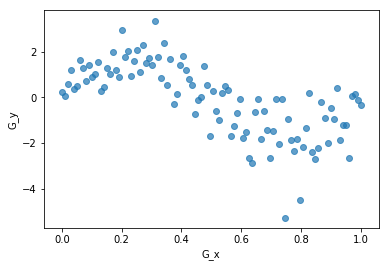

In [ ]:
plt.scatter(G_x, G_y, alpha=0.7)
plt.xlabel('G_x')
plt.ylabel('G_y')

#### So we observe these 1000 data points, but let's visualize what the true data generating function really looks like. Below I plot the concentric intervals covering probabilities of 20%, 40%, 60%, and 80%. Note that this code is adapted from Michael Betancourt's nice tutorial: https://betanalpha.github.io/assets/case_studies/gp_part1/part1.html

In [ ]:
# helper function to visualize data
def plot_percentiles(xs, ys):

    probs = [10, 20, 30, 40, 50, 60, 70, 80, 90]

    percentiles = [np.percentile(ys, prob, axis=0) for prob in probs]

    light="#DCBCBC"
    light_highlight="#C79999"
    mid="#B97C7C"
    mid_highlight="#A25050"
    dark="#8F2727"
    dark_highlight="#7C0000"
    green="#00FF00"

    plt.fill_between(xs, percentiles[0], percentiles[8],
                  facecolor=light, color=light)
    plt.fill_between(xs, percentiles[1], percentiles[7],
                  facecolor=light_highlight, color=light_highlight)
    plt.fill_between(xs, percentiles[2], percentiles[6],
                      facecolor=mid, color=mid)
    plt.fill_between(xs, percentiles[3], percentiles[5],
                      facecolor=mid_highlight, color=mid_highlight)
    plt.plot(xs, percentiles[4], color=dark)



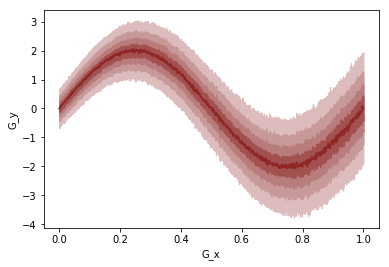

In [ ]:
xs = np.linspace(0,1,1000)
ys = 2*np.sin(2*np.pi*xs) + np.random.normal(loc=0, scale=(0.5+1*xs), size=(1000,1000))
plot_percentiles(xs, ys)
plt.xlabel('G_x')
plt.ylabel('G_y');

### Let's plot both our observed data and the true data generating process to get an idea of how representative our data is

Text(0, 0.5, 'G_y')

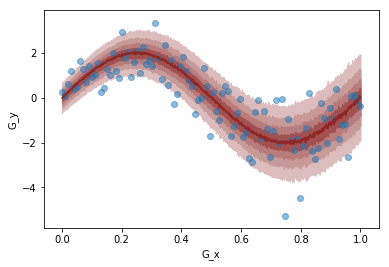

In [ ]:
plot_percentiles(xs, ys)

plt.scatter(G_x, G_y, alpha=0.5)
plt.xlabel('G_x')
plt.ylabel('G_y')

### In order to work with a heteroskedatic model, we must first have an exstimate of the noise at each training point. To do this, I will construct a normal GP first.

Let's use the SingleTaskGP function in BoTorch to do this:

In [ ]:
from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan

model = SingleTaskGP(train_X=X_train, train_Y=y_train)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

In [ ]:
from gpytorch.mlls import ExactMarginalLogLikelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

In [ ]:
mll.train()
botorch.optim.fit.fit_gpytorch_scipy(mll)

(ExactMarginalLogLikelihood(
   (likelihood): GaussianLikelihood(
     (quadrature): GaussHermiteQuadrature1D()
     (noise_covar): HomoskedasticNoise(
       (noise_prior): GammaPrior()
       (raw_noise_constraint): GreaterThan(1.000E-05)
     )
   )
   (model): SingleTaskGP(
     (likelihood): GaussianLikelihood(
       (quadrature): GaussHermiteQuadrature1D()
       (noise_covar): HomoskedasticNoise(
         (noise_prior): GammaPrior()
         (raw_noise_constraint): GreaterThan(1.000E-05)
       )
     )
     (mean_module): ConstantMean()
     (covar_module): ScaleKernel(
       (base_kernel): MaternKernel(
         (lengthscale_prior): GammaPrior()
         (raw_lengthscale_constraint): Positive()
         (distance_module): Distance()
       )
       (outputscale_prior): GammaPrior()
       (raw_outputscale_constraint): Positive()
     )
   )
 ),
 [OptimizationIteration(itr=0, fun=1.5219557285308838, time=0.14128994941711426),
  OptimizationIteration(itr=1, fun=1.5020115375518

In [ ]:
# test on the training points
# call if X_test just for ease of use in future
X_test = torch.linspace(0,1,100)

mll.eval()
with torch.no_grad():
    posterior = mll.model.posterior(X_test)
    test_pred = mll.likelihood(mll.model(X_test))

/usr/local/lib/python3.6/dist-packages/gpytorch/models/exact_gp.py:221: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


Text(0.5, 1.0, 'Initial Homoskedastic GP')

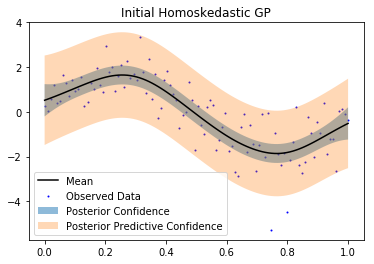

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(6, 4))

    # fit posterior confidence
    lower, upper = posterior.mvn.confidence_region()
    # Get upper and lower predictive confidence bounds
    lower_predictive, upper_predictive = test_pred.confidence_region()
    # Plot training data
    ax.scatter(X_train.numpy(), y_train.numpy(), c='b', s=1)
    # Plot predictive means as blue line
    ax.plot(X_test, posterior.mean.numpy(), 'k-')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(X_test.numpy(),
                    lower.numpy(),
                    upper.numpy(), alpha=0.5)
    ax.fill_between(X_test.numpy(),
                    lower_predictive.numpy(),
                    upper_predictive.numpy(),
                    alpha=0.3)
    ax.legend(['Mean', 'Observed Data', 'Posterior Confidence',
               'Posterior Predictive Confidence'])

plt.title('Initial Homoskedastic GP')

Let's see how well the predictive posterior matches the actual data distribution:

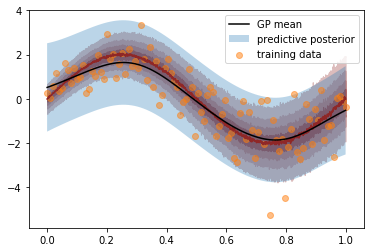

In [ ]:
plot_percentiles(xs, ys)

with torch.no_grad():

    # Get upper and lower confidence bounds
    lower_predictive, upper_predictive = test_pred.confidence_region()
    # Plot predictive means as blue line
    plt.plot(X_test, posterior.mean.numpy(), 'k-', label='GP mean')
    plt.fill_between(X_test.numpy(),
                    lower_predictive.numpy(),
                    upper_predictive.numpy(),
                    alpha=0.3, label='predictive posterior')

plt.scatter(G_x, G_y, alpha=0.5, label='training data')
plt.legend()

As you can see, the learned GP does not appropriately model the noise at the lower x values.

Now that our initial GP is built, let's estimate the variance by calculating the squared error at each training point. We can then feed that into the heteroskedastic GP.

In [ ]:
with torch.no_grad():
    # watch broadcasting here
    observed_var = torch.tensor(
                       np.power(mll.model.posterior(X_train).mean.numpy().reshape(-1,) - y_train.numpy(), 2),
                       dtype=torch.float
    )

## Train the heteroskedastic GP ##

In [ ]:
from botorch.models import HeteroskedasticSingleTaskGP
model = HeteroskedasticSingleTaskGP(train_X=X_train, train_Y=y_train,
                                    train_Yvar=observed_var)

In [ ]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

In [ ]:
mll.train()
botorch.optim.fit.fit_gpytorch_scipy(mll)

(ExactMarginalLogLikelihood(
   (likelihood): _GaussianLikelihoodBase(
     (quadrature): GaussHermiteQuadrature1D()
     (noise_covar): HeteroskedasticNoise(
       (noise_model): SingleTaskGP(
         (likelihood): GaussianLikelihood(
           (quadrature): GaussHermiteQuadrature1D()
           (noise_covar): HomoskedasticNoise(
             (noise_prior): SmoothedBoxPrior()
             (raw_noise_constraint): GreaterThan(1.000E-06)
           )
         )
         (mean_module): ConstantMean()
         (covar_module): ScaleKernel(
           (base_kernel): MaternKernel(
             (lengthscale_prior): GammaPrior()
             (raw_lengthscale_constraint): Positive()
           )
           (outputscale_prior): GammaPrior()
           (raw_outputscale_constraint): Positive()
         )
       )
       (_noise_constraint): GreaterThan(1.000E-04)
     )
   )
   (model): HeteroskedasticSingleTaskGP(
     (likelihood): _GaussianLikelihoodBase(
       (quadrature): GaussHermiteQuad

In [ ]:
# test on the training points
# call if X_test just for ease of use in future
X_test = torch.linspace(0,1,100)

mll.eval()
with torch.no_grad():
    posterior = mll.model.posterior(X_test)
    # test_pred = mll.likelihood(mll.model(X_test))
    # above doesn't work here

Text(0.5, 1.0, 'Heteroskedastic GP')

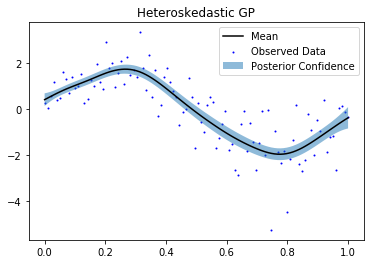

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(6, 4))

    # fit posterior confidence
    lower, upper = posterior.mvn.confidence_region()
    # Plot training data
    ax.scatter(X_train.numpy(), y_train.numpy(), c='b', s=1)
    # Plot predictive means as blue line
    ax.plot(X_test, posterior.mean.numpy(), 'k-')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(X_test.numpy(),
                    lower.numpy(),
                    upper.numpy(), alpha=0.5)

    ax.legend(['Mean', 'Observed Data', 'Posterior Confidence'])

plt.title('Heteroskedastic GP')

### Let's see if I can find out a way to get the posterior predictive confidence region

In [ ]:
mll.model.likelihood.noise_covar.noise_model.posterior(X_test).mean

tensor([[-2.7113],
        [-2.6818],
        [-2.6484],
        [-2.6116],
        [-2.5725],
        [-2.5318],
        [-2.4906],
        [-2.4497],
        [-2.4096],
        [-2.3707],
        [-2.3333],
        [-2.2977],
        [-2.2642],
        [-2.2333],
        [-2.2051],
        [-2.1799],
        [-2.1576],
        [-2.1382],
        [-2.1212],
        [-2.1063],
        [-2.0927],
        [-2.0794],
        [-2.0651],
        [-2.0485],
        [-2.0284],
        [-2.0035],
        [-1.9734],
        [-1.9377],
        [-1.8968],
        [-1.8511],
        [-1.8018],
        [-1.7507],
        [-1.6994],
        [-1.6500],
        [-1.6039],
        [-1.5625],
        [-1.5264],
        [-1.4956],
        [-1.4696],
        [-1.4472],
        [-1.4267],
        [-1.4063],
        [-1.3842],
        [-1.3588],
        [-1.3290],
        [-1.2946],
        [-1.2556],
        [-1.2127],
        [-1.1667],
        [-1.1188],
        [-1.0700],
        [-1.0215],
        [-0.

Since these numbers are all negative, I think they still must be the log of the variance:

In [ ]:
mll.eval()
with torch.no_grad():
    predictive_noise = torch.exp(mll.model.likelihood.noise_covar.noise_model.posterior(X_test).mean)
    # get standard deviation
    predictive_noise_std = torch.sqrt(predictive_noise).squeeze(-1)

Text(0.5, 1.0, 'Heteroskedastic GP')

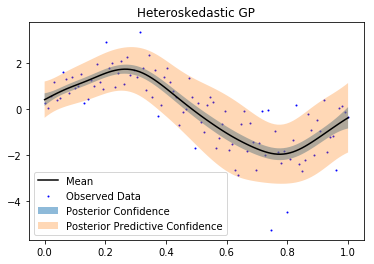

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(6, 4))

    # fit posterior confidence
    lower, upper = posterior.mvn.confidence_region()
    # get posterior predictive confidence by adding noise from noise model
    lower_predictive = lower - 2*predictive_noise_std
    upper_predictive = upper + 2*predictive_noise_std

    # Plot training data
    ax.scatter(X_train.numpy(), y_train.numpy(), c='b', s=1)
    # Plot predictive means as blue line
    ax.plot(X_test, posterior.mean.numpy(), 'k-')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(X_test.numpy(),
                    lower.numpy(),
                    upper.numpy(), alpha=0.5)
    ax.fill_between(X_test.numpy(),
                    lower_predictive.numpy(),
                    upper_predictive.numpy(),
                    alpha=0.3)
    ax.legend(['Mean', 'Observed Data', 'Posterior Confidence',
               'Posterior Predictive Confidence'])
plt.title('Heteroskedastic GP')

Again, let's overlay this with the true data generating process:

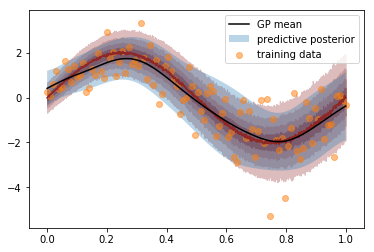

In [ ]:
plot_percentiles(xs, ys)

with torch.no_grad():

    # fit posterior confidence
    lower, upper = posterior.mvn.confidence_region()
    # get posterior predictive confidence by adding noise from noise model
    lower_predictive = lower - 2*predictive_noise_std
    upper_predictive = upper + 2*predictive_noise_std
    # Plot predictive means as blue line
    plt.plot(X_test, posterior.mean.numpy(), 'k-', label='GP mean')
    plt.fill_between(X_test.numpy(),
                    lower_predictive.numpy(),
                    upper_predictive.numpy(),
                    alpha=0.3, label='predictive posterior')

plt.scatter(G_x, G_y, alpha=0.5, label='training data')
plt.legend()

That's pretty cool.

Let's see if we can wrap it all up in a function:

In [ ]:
def MyHeteroskedasticGP(X_train, y_train):

    model = SingleTaskGP(train_X=X_train, train_Y=y_train)
    model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

    mll.train()
    botorch.optim.fit.fit_gpytorch_scipy(mll)

    mll.eval()
    # test on the training points
    # call if X_test just for ease of use
    X_test = X_train.clone()

    mll.eval()
    with torch.no_grad():
        posterior = mll.model.posterior(X_test)
        test_pred = mll.likelihood(mll.model(X_test))

    with torch.no_grad():
        # watch broadcasting here
        observed_var = torch.tensor(
                           np.power(mll.model.posterior(X_train).mean.numpy().reshape(-1,) - y_train.numpy(), 2),
                           dtype=torch.float
        )

    # NOW TRAIN HETERO MODEL
    model = HeteroskedasticSingleTaskGP(train_X=X_train, train_Y=y_train,
                                    train_Yvar=observed_var)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

    mll.train()
    botorch.optim.fit.fit_gpytorch_scipy(mll)

    return mll

#     mll.eval()
#     with torch.no_grad():
#         posterior = mll.model.posterior(X_test)

#         predictive_noise = torch.exp(mll.model.likelihood.noise_covar.noise_model.posterior(X_test).mean)
#         # get standard deviation
#         predictive_noise_std = torch.sqrt(predictive_noise).squeeze(-1)


# Let's try a new dataset:

In [ ]:
# W : 200 input xi are drawn from a uniform distribution on [0, π].
# The targets ti are distributed according to a Gaussian with mean sin(2.5xi)·sin(1.5xi)
# and standard deviation 0.01 + 0.25(1 − sin(2.5xi))2

W_x = np.random.uniform(0, np.pi, size=200)
W_x = np.sort(W_x)
W_y = np.random.normal(loc=(np.sin(2.5*W_x)*np.sin(1.5*W_x)),
                       scale=(0.01 + 0.25*(1-np.sin(2.5*W_x))**2),
                       size=200)

In [ ]:
X_train = torch.tensor(W_x.reshape(-1,1), dtype=torch.float)
y_train = torch.tensor(W_y, dtype=torch.float)

Text(0, 0.5, 'W_y')

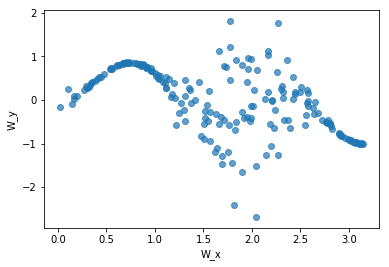

In [ ]:
plt.scatter(W_x, W_y, alpha=0.7)
plt.xlabel('W_x')
plt.ylabel('W_y')

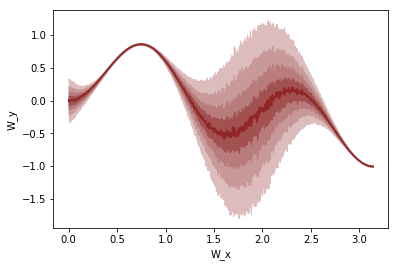

In [ ]:
xs = np.linspace(0,np.pi,1000)
ys = np.random.normal(loc=(np.sin(2.5*xs)*np.sin(1.5*xs)),
                       scale=(0.01 + 0.25*(1-np.sin(2.5*xs))**2),
                       size=(1000,1000))
plot_percentiles(xs, ys)
plt.xlabel('W_x')
plt.ylabel('W_y');

Text(0, 0.5, 'W_y')

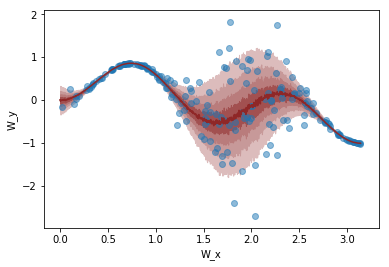

In [ ]:
plot_percentiles(xs, ys)

plt.scatter(W_x, W_y, alpha=0.5)
plt.xlabel('W_x')
plt.ylabel('W_y')

In [ ]:
mll = MyHeteroskedasticGP(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/gpytorch/models/exact_gp.py:221: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


In [ ]:
X_test=X_train.squeeze(-1)
mll.eval()
with torch.no_grad():
    posterior = mll.model.posterior(X_test)

    predictive_noise = torch.exp(mll.model.likelihood.noise_covar.noise_model.posterior(X_test).mean)
    # get standard deviation
    predictive_noise_std = torch.sqrt(predictive_noise).squeeze(-1)


Text(0.5, 1.0, 'Heteroskedastic GP')

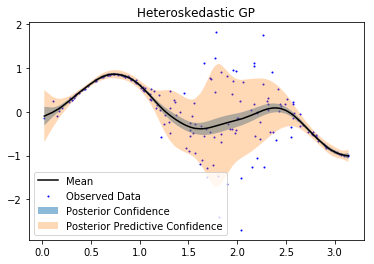

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(6, 4))

    # fit posterior confidence
    lower, upper = posterior.mvn.confidence_region()
    # get posterior predictive confidence by adding noise from noise model
    lower_predictive = lower - 2*predictive_noise_std
    upper_predictive = upper + 2*predictive_noise_std

    # Plot training data
    ax.scatter(X_train.numpy(), y_train.numpy(), c='b', s=1)
    # Plot predictive means as blue line
    ax.plot(X_test, posterior.mean.numpy(), 'k-')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(X_test.numpy(),
                    lower.numpy(),
                    upper.numpy(), alpha=0.5)
    ax.fill_between(X_test.numpy(),
                    lower_predictive.numpy(),
                    upper_predictive.numpy(),
                    alpha=0.3)
    ax.legend(['Mean', 'Observed Data', 'Posterior Confidence',
               'Posterior Predictive Confidence'])
plt.title('Heteroskedastic GP')

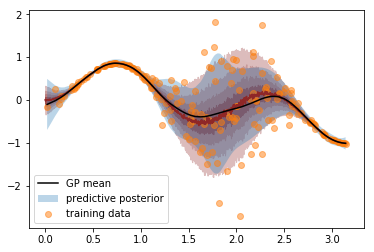

In [ ]:
plot_percentiles(xs, ys)

with torch.no_grad():

    # fit posterior confidence
    lower, upper = posterior.mvn.confidence_region()
    # get posterior predictive confidence by adding noise from noise model
    lower_predictive = lower - 2*predictive_noise_std
    upper_predictive = upper + 2*predictive_noise_std
    # Plot predictive means as blue line
    plt.plot(X_test, posterior.mean.numpy(), 'k-', label='GP mean')
    plt.fill_between(X_test.numpy(),
                    lower_predictive.numpy(),
                    upper_predictive.numpy(),
                    alpha=0.3, label='predictive posterior')

plt.scatter(W_x, W_y, alpha=0.5, label='training data')
plt.legend()

### Part of the problem here was our lack of training data, but let's dry it again with more training points:

In [ ]:
W_x = np.random.uniform(0, np.pi, size=2500)
W_x = np.sort(W_x)
W_y = np.random.normal(loc=(np.sin(2.5*W_x)*np.sin(1.5*W_x)),
                       scale=(0.01 + 0.25*(1-np.sin(2.5*W_x))**2),
                       size=2500)

In [ ]:
X_train = torch.tensor(W_x.reshape(-1,1), dtype=torch.float)
y_train = torch.tensor(W_y, dtype=torch.float)

Text(0, 0.5, 'W_y')

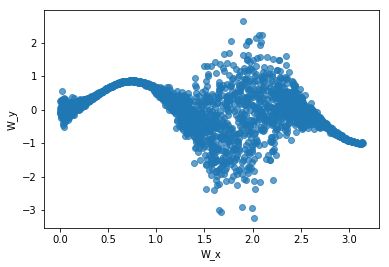

In [ ]:
plt.scatter(W_x, W_y, alpha=0.7)
plt.xlabel('W_x')
plt.ylabel('W_y')

In [ ]:
mll = MyHeteroskedasticGP(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/gpytorch/models/exact_gp.py:221: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


In [ ]:
X_test=X_train.squeeze(-1)
mll.eval()
with torch.no_grad():
    posterior = mll.model.posterior(X_test)

    predictive_noise = torch.exp(mll.model.likelihood.noise_covar.noise_model.posterior(X_test).mean)
    # get standard deviation
    predictive_noise_std = torch.sqrt(predictive_noise).squeeze(-1)

Text(0.5, 1.0, 'Heteroskedastic GP')

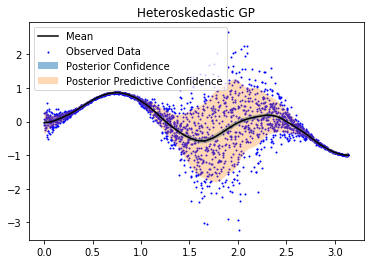

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(6, 4))

    # fit posterior confidence
    lower, upper = posterior.mvn.confidence_region()
    # get posterior predictive confidence by adding noise from noise model
    lower_predictive = lower - 2*predictive_noise_std
    upper_predictive = upper + 2*predictive_noise_std

    # Plot training data
    ax.scatter(X_train.numpy(), y_train.numpy(), c='b', s=1)
    # Plot predictive means as blue line
    ax.plot(X_test, posterior.mean.numpy(), 'k-')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(X_test.numpy(),
                    lower.numpy(),
                    upper.numpy(), alpha=0.5)
    ax.fill_between(X_test.numpy(),
                    lower_predictive.numpy(),
                    upper_predictive.numpy(),
                    alpha=0.3)
    ax.legend(['Mean', 'Observed Data', 'Posterior Confidence',
               'Posterior Predictive Confidence'])
plt.title('Heteroskedastic GP')

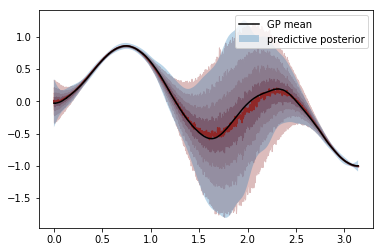

In [ ]:
plot_percentiles(xs, ys)

with torch.no_grad():

    # fit posterior confidence
    lower, upper = posterior.mvn.confidence_region()
    # get posterior predictive confidence by adding noise from noise model
    lower_predictive = lower - 2*predictive_noise_std
    upper_predictive = upper + 2*predictive_noise_std
    # Plot predictive means as blue line
    plt.plot(X_test, posterior.mean.numpy(), 'k-', label='GP mean')
    plt.fill_between(X_test.numpy(),
                    lower_predictive.numpy(),
                    upper_predictive.numpy(),
                    alpha=0.3, label='predictive posterior')

#plt.scatter(W_x, W_y, alpha=0.1, label='training data')
plt.legend()

# Looks pretty decent!

In [ ]:
# should also do it where I actuall feed in the known variance at the end